# TechNova Attrition Analysis - Prédisez et comprenez le turnover des employés.

<div align="left">
  <img src="../docs/images/logo_technova.png" width="200px" alt="Logo TechNova Partners">
</div>

## **Objectif**: Identifier les causes racines de l'attrition et prédire le départ des collaborateurs à l'aide de **XGBoost** et **SHAP**.

# <span style="color:red"> 🏷️ Étape 3 - Réalisation d’un premier modèle de classification</span>


# ⬇️ IMPORTATION DES LIBRAIRIES (STACK DE SCIENCE DES DONNÉES)

In [22]:
# ##############################################################################
# ENVIRONNEMENT DE DÉVELOPPEMENT ET CALCUL NUMÉRIQUE
# ##############################################################################
import os                                     # Interface système de fichiers
import time                                   # Mesure des temps d'exécution
import warnings                               # Gestion des alertes (filtres)
import numpy              as np               # Algèbre linéaire et tableaux
import pandas             as pd               # Analyse et structures de données
import matplotlib.pyplot  as plt              # Bibliothèque de traçage de base
import seaborn            as sns              # Visualisation statistique avancée

from pathlib              import Path         # Manipulation moderne de chemins
from typing               import (            # Support du typage statique
    Dict, Tuple, List, Any, Optional, Union
)

# Configuration globale des alertes
warnings.filterwarnings('ignore')             # Nettoyage de la sortie console

# ##############################################################################
# SCIKIT-LEARN : INFRASTRUCTURE ET VALIDATION
# ##############################################################################
from sklearn.model_selection import (
    train_test_split,                         # Division train/test des données
    cross_validate,                           # Évaluation par validation croisée
    StratifiedKFold                           # Découpage stratifié des plis (folds)
)

# ##############################################################################
# SCIKIT-LEARN : MODÈLES ET ALGORITHMES
# ##############################################################################
from sklearn.dummy        import DummyClassifier    # Modèle de référence (Baseline)
from sklearn.linear_model import LogisticRegression # Modèle linéaire classique
from sklearn.ensemble     import (
    RandomForestClassifier,                   # Forêts d'arbres décisionnels
    GradientBoostingClassifier                # Boosting d'arbres standard
)

# ##############################################################################
# SCIKIT-LEARN : MÉTRIQUES DE PERFORMANCE
# ##############################################################################
from sklearn.metrics      import (
    make_scorer,                              # Création de fonctions de score
    classification_report,                    # Rapport de synthèse par classe
    confusion_matrix,                         # Matrice d'erreurs de prédiction
    accuracy_score,                           # Taux de prédiction correcte
    precision_score,                          # Pureté des prédictions positives
    recall_score,                             # Capacité de détection des positifs
    f1_score,                                 # Équilibre Précision/Rappel
    roc_auc_score,                            # Score de discrimination (AUC)
    roc_curve,                                # Points de la courbe ROC
    auc,                                      # Calcul de l'aire sous la courbe
    precision_recall_curve,                   # Points de la courbe PR
    average_precision_score,                  # Moyenne de précision (AP)
    matthews_corrcoef,                        # Coefficient de corrélation MCC
    cohen_kappa_score                         # Indice de fiabilité Kappa
)

# ##############################################################################
# LIBRAIRIES DE BOOSTING AVANCÉES (GESTION DES DÉPENDANCES)
# ##############################################################################
try:
    from xgboost import XGBClassifier         # Algorithme Extreme Gradient Boosting
    XGBOOST_AVAILABLE = True                  # Indicateur de présence XGBoost
except ImportError:
    XGBOOST_AVAILABLE = False                 # Gestion si librairie manquante

try:
    from catboost import CatBoostClassifier   # Algorithme Gradient Boosting (Categorical)
    CATBOOST_AVAILABLE = True                 # Indicateur de présence CatBoost
except ImportError:
    CATBOOST_AVAILABLE = False                # Gestion si librairie manquante

# ##############################################################################
# RAPPORT DES VERSIONS ET CONFIGURATION INITIALE
# ##############################################################################

print("\n============================================================================")
print("AUDIT DE L'ENVIRONNEMENT DE MODÉLISATION")
print("============================================================================")
print(f"  Version Pandas......: {pd.__version__}")
print(f"  Version Numpy.......: {np.__version__}")
print(f"  XGBoost disponible..: {'✅ OUI' if XGBOOST_AVAILABLE else '❌ NON'}")
print(f"  CatBoost disponible.: {'✅ OUI' if CATBOOST_AVAILABLE else '❌ NON'}")
print("-" * 80)



AUDIT DE L'ENVIRONNEMENT DE MODÉLISATION
  Version Pandas......: 2.3.3
  Version Numpy.......: 2.2.2
  XGBoost disponible..: ✅ OUI
  CatBoost disponible.: ✅ OUI
--------------------------------------------------------------------------------


### Installation de CatBoost

In [23]:
import sys
print(sys.version)

3.12.12 (main, Jan 14 2026, 19:30:21) [MSC v.1944 64 bit (AMD64)]


# Réinstaller pip via le module ensurepip :
!{sys.executable} -m ensurepip --upgrade

# Mise à jour de pip
!{sys.executable} -m pip install --upgrade pip

# Installation du package CatBoost via le gestionnaire pip
!{sys.executable} -m pip install catboost

# Installation du package imbalanced

# ⚙️ CONFIGURATION GLOBALE DU PROJET

In [24]:
# Configuration des chemins
RAW_DATA_DIR     = Path("../data/raw")
INTERIM_DATA_DIR = Path("../data/interim")
PREPROCESED_DIR  = Path("../data/processed")
REPORTS_DIR      = Path("../reports")
MODELS_DIR       = Path("../models/V1")                # Use a folder for each Version 


MODEL_DummyClassifier        = 'Baseline_Aleatoire'
MODEL_LogisticRegression     = 'Regression_Logistique'
MODEL_RandomForestClassifier = 'Random_Forest'
MODEL_XGBClassifier          = 'XGBoost_Advanced'
MODEL_CatBoostClassifier     = 'CatBoost_Elite'


# ============================================================================
# CONFIGURATION GLOBALE DU PROJET
# ============================================================================

# Définition de la variable cible du projet (Target)
FEATURE_TARGET           = "attrition_binary"
FEATURE_TARGET_INITIAL   = "a_quitte_l_entreprise"

# 1. Supprimer la limite de largeur de la console (définie à None)
pd.set_option('display.expand_frame_repr', False)

# 2. S’assurer que la largeur des colonnes est suffisante pour les noms longs
pd.set_option('display.max_colwidth', None)

# 3. (Optionnel) Si il y a beaucoup de lignes, on peut contrôler combien en afficher
pd.set_option('display.max_rows', 100)

# ----------------------------------------------------------------------------
# RAPPORT DE CONFIGURATION
# ----------------------------------------------------------------------------
print("\n============================================================================")
print("PARAMÈTRES DE CONFIGURATION INITIALISÉS")
print("============================================================================")
print(f"  Variable cible (Target)...........: {FEATURE_TARGET}")
print(f"  Variable cible iniital (Target)...: {FEATURE_TARGET_INITIAL}")
print("  Status............................: ✅ Configuration prête")
print("============================================================================")



PARAMÈTRES DE CONFIGURATION INITIALISÉS
  Variable cible (Target)...........: attrition_binary
  Variable cible iniital (Target)...: a_quitte_l_entreprise
  Status............................: ✅ Configuration prête


## ❇️ LOAD AND EXPLORE DATASET MERGED

In [25]:
# 1. Chargement des fichiers
input_path = PREPROCESED_DIR / "data_final.csv"
df_final    = pd.read_csv(input_path )
print(df_final.info())                                       # Vérification des types Dtype (int, float, object)
display(df_final.head(3))   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 44 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   n_log__revenu_mensuel                             1470 non-null   float64
 1   n_log__annee_experience_totale                    1470 non-null   float64
 2   n_log__annees_dans_l_entreprise                   1470 non-null   float64
 3   n_log__annees_depuis_la_derniere_promotion        1470 non-null   float64
 4   n_std__age                                        1470 non-null   float64
 5   n_std__nombre_experiences_precedentes             1470 non-null   float64
 6   n_std__annees_dans_le_poste_actuel                1470 non-null   float64
 7   n_std__satisfaction_employee_environnement        1470 non-null   float64
 8   n_std__note_evaluation_precedente                 1470 non-null   float64
 9   n_std__satisfaction

,n_log__revenu_mensuel,n_log__annee_experience_totale,n_log__annees_dans_l_entreprise,n_log__annees_depuis_la_derniere_promotion,n_std__age,n_std__nombre_experiences_precedentes,n_std__annees_dans_le_poste_actuel,n_std__satisfaction_employee_environnement,n_std__note_evaluation_precedente,n_std__satisfaction_employee_nature_travail,...,c_ohe__domaine_etude_Autre,c_ohe__domaine_etude_Entrepreunariat,c_ohe__domaine_etude_Infra & Cloud,c_ohe__domaine_etude_Marketing,c_ohe__domaine_etude_Ressources Humaines,c_ohe__domaine_etude_Transformation Digitale,c_ohe__frequence_deplacement_Aucun,c_ohe__frequence_deplacement_Frequent,c_ohe__frequence_deplacement_Occasionnel,attrition_binary
0,0.218262,-0.148970,0.178857,-0.974295,0.446350,2.125136,-0.063296,-0.660531,0.379672,1.153254,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,-0.017266,0.144921,0.777704,-0.116765,1.322365,-0.678049,0.764998,0.254625,-1.026167,-0.660853,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,-1.377263,-0.321469,-2.399329,-0.974295,0.008343,1.324226,-1.167687,1.169781,-1.026167,0.246200,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


## ⬇️ Import Classe auxiliare pour analyse (DataCleaner)

In [26]:
# ==================================================================================================
# INITIALISATION DU MOTEUR DE NETTOYAGE (DATA CLEANING)
# ==================================================================================================

# Importation de la classe personnalisée d'ingénierie des données
# Cette classe encapsule les règles métier spécifiques au dataset de Seattle.
from DataCleaner  import DataCleaner                # Module de nettoyage propriétaire

# Initialisation du nettoyeur global
# verbose=True permet d'éditer un rapport détaillé des transformations effectuées.
cleaner           = DataCleaner(
                           df      = df_final,      # Source des données brutes
                           verbose = True              # Activation des logs détaillés
)

# --------------------------------------------------------------------------------------------------
# RAPPORT D'ÉTAT DU NETTOYEUR
# --------------------------------------------------------------------------------------------------
print("\n==================================================================================================")
print("INSTANCIATION DU MOTEUR DE NETTOYAGE")
print("==================================================================================================")
print(f"  Objet créé............: {type(cleaner).__name__}")
print(f"  Mode verbeux..........: Activé (Diagnostic temps réel)")
print(f"  Source de données.....: dataset_raw (ID: {id(df_final)})")
print(f"  Statut................: ✅ Prêt pour l'étape de transformation")
print("==================================================================================================\n")


INSTANCIATION DU MOTEUR DE NETTOYAGE
  Objet créé............: DataCleaner
  Mode verbeux..........: Activé (Diagnostic temps réel)
  Source de données.....: dataset_raw (ID: 1821410437952)
  Statut................: ✅ Prêt pour l'étape de transformation



## ⬇️ Import Classe auxiliare pour modelisation (ClassificationModeler)

In [27]:
from ClassificationModeler import ClassificationModeler

# ✂️ Step 1. Split stratifié (prepare_train_test_split) 

In [28]:
# Rien a suprimer, le dataset est deja pret.
cleaner.FEATURES_TO_REMOVE  =  []

# Appel de ta fonction
X_prep, y_prep   = cleaner.pipeline_preparation_initiale( df           = cleaner.df, 
                                                          target       = FEATURE_TARGET, 
                                                          cols_to_drop = cleaner.FEATURES_TO_REMOVE
                                                         )
# Commencer par réaliser une séparation train test simple ou une validation croisée simple.
X_train, X_test, y_train, y_test = train_test_split( X_prep, y_prep, test_size=0.2, random_state=42)

# ----------------------------------------------------------------------------
# RAPPORT DE SEGMENTATION DES DONNÉES
# ----------------------------------------------------------------------------
# Calcul des proportions pour vérification
prop_train       = (len(X_train) / len(X_prep)) * 100
prop_test        = (len(X_test)  / len(X_prep)) * 100

print("\n============================================================================")
print("BILAN DU PARTITIONNEMENT (TRAIN/TEST SPLIT)")
print("============================================================================")
print(f"  Taille totale dataset.: {len(X_prep)}  lignes")
print(f"  Ensemble Train........: {len(X_train)} lignes ({prop_train:.1f}%)")
print(f"  Ensemble Test.........: {len(X_test)}  lignes ({prop_test:.1f}%)")
print(f"  Variables prédictives.: {X_train.shape[1]}")
print("  Status................: ✅ Segmentation effectuée avec succès")
print("============================================================================")


--- Nettoyage des colonnes ---
------------------------------------------------------------
🎯 CIBLE (y)      : attrition_binary
🧬 FEATURES (X)   : ['n_log__revenu_mensuel', 'n_log__annee_experience_totale', 'n_log__annees_dans_l_entreprise', 'n_log__annees_depuis_la_derniere_promotion', 'n_std__age', 'n_std__nombre_experiences_precedentes', 'n_std__annees_dans_le_poste_actuel', 'n_std__satisfaction_employee_environnement', 'n_std__note_evaluation_precedente', 'n_std__satisfaction_employee_nature_travail', 'n_std__satisfaction_employee_equipe', 'n_std__satisfaction_employee_equilibre_pro_perso', 'n_std__note_evaluation_actuelle', 'n_std__heure_supplementaires', 'n_std__augementation_salaire_precedente', 'n_std__nombre_participation_pee', 'n_std__nb_formations_suivies', 'n_std__distance_domicile_travail', 'n_std__niveau_education', 'n_std__annes_sous_responsable_actuel', 'c_ohe__genre_F', 'c_ohe__genre_M', 'c_ohe__statut_marital_Célibataire', 'c_ohe__statut_marital_Divorcé(e)', 'c_ohe__

# 🔗 Step 2. INITIALISATION DU CLASSIFICATION MODELER

In [29]:
# Initialisation du Modélisateur. Instanciar el Modeler
# El print de inicialización te dará el resumen de la configuración automáticamente
# --------------------------------------------------------------------------
modeler = ClassificationModeler(X_train , y_train, X_test, y_test)


🎯 CLASSIFICATION MODELER INITIALISÉ
  Samples Train.......: 1176
  Features Train......: 43
  Samples Test........: 294

  DISTRIBUTION DES CLASSES (TRAIN) :
    Classe 0..........: 83.16%
    Classe 1..........: 16.84%

  DISTRIBUTION DES CLASSES (TEST) :
    Classe 0..........: 86.73%
    Classe 1..........: 13.27%

  ⚠️  DATASET DÉSÉQUILIBRÉ (Ratio 4.94:1)
     Conseil : Utiliser class_weight='balanced' dans vos modèles

  Random State........: 42
  CV Folds (Stratified): 5
  Seuil de Décision...: 0.5
  Métriques actives...: ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'log_loss']



# ⏳ Step 3. Entraînements Individuels

## 🏋️‍♂️ Training Dummy Model

In [30]:
# --------------------------------------------------------------------------
# Baseline : Modèle aléatoire stratifié
modeler.entrainer_modele(  DummyClassifier(strategy='stratified'), 
                           'Baseline_Aleatoire'
                        )


🎯 EXPÉRIENCE #1 : Baseline_Aleatoire

🔄 Validation Croisée Stratifiée (5 plis)...
   Résultats :
   ACCURACY   → Train: 0.7253 (±0.0042) | CV: 0.7186 (±0.0328)
   PRECISION  → Train: 0.1863 (±0.0156) | CV: 0.1892 (±0.0549)
   RECALL     → Train: 0.1881 (±0.0206) | CV: 0.1968 (±0.0483)
   F1         → Train: 0.1872 (±0.0180) | CV: 0.1916 (±0.0484)
   ROC_AUC    → Train: 0.5037 (±0.0239) | CV: 0.5048 (±0.0428)
   LOG_LOSS   → Train: 9.9226 (±0.4665) | CV: 10.2366 (±0.7180)

🏋️  Entraînement sur 1176 échantillons...
   ✅ Complété en 0.00s

🔮 Génération des prédictions...
   Train - Classe positive: 17.52%
   Test  - Classe positive: 18.37%

✅ Généralisation optimale (pas d'overfitting)

──────────────────────────────────────────────────────────────────────
📊 RAPPORT DE CLASSIFICATION (Baseline_Aleatoire)
──────────────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       255
      

{'id_experience': 1,
 'nom_modele': 'Baseline_Aleatoire',
 'modele': DummyClassifier(strategy='stratified'),
 'scores_cv': {'accuracy': {'train_moyenne': np.float64(0.7253406290275172),
   'train_ecart': np.float64(0.004196036796524547),
   'cv_moyenne': np.float64(0.7185683375405698),
   'cv_ecart': np.float64(0.032812212469325364)},
  'precision': {'train_moyenne': np.float64(0.18633966374687477),
   'train_ecart': np.float64(0.015646686565497354),
   'cv_moyenne': np.float64(0.18919433892755805),
   'cv_ecart': np.float64(0.05494440230374868)},
  'recall': {'train_moyenne': np.float64(0.18810604251253882),
   'train_ecart': np.float64(0.020643532601913282),
   'cv_moyenne': np.float64(0.1967948717948718),
   'cv_ecart': np.float64(0.04832159960952393)},
  'f1': {'train_moyenne': np.float64(0.18715628582181373),
   'train_ecart': np.float64(0.01803819205701298),
   'cv_moyenne': np.float64(0.19158233900693625),
   'cv_ecart': np.float64(0.0483641351402221)},
  'roc_auc': {'train_moye

## 🏋️‍♂️ Training Logistic Regression

In [31]:
# Modèle Linéaire : Régression Logistique
modeler.entrainer_modele(
    LogisticRegression(max_iter=1000, class_weight='balanced'), 
    'Regression_Logistique'
)


🎯 EXPÉRIENCE #2 : Regression_Logistique

🔄 Validation Croisée Stratifiée (5 plis)...
   Résultats :
   ACCURACY   → Train: 0.8061 (±0.0114) | CV: 0.7891 (±0.0169)
   PRECISION  → Train: 0.4583 (±0.0184) | CV: 0.4299 (±0.0295)
   RECALL     → Train: 0.8282 (±0.0247) | CV: 0.7772 (±0.0626)
   F1         → Train: 0.5900 (±0.0214) | CV: 0.5534 (±0.0394)
   ROC_AUC    → Train: 0.8822 (±0.0099) | CV: 0.8486 (±0.0334)
   LOG_LOSS   → Train: 0.4254 (±0.0139) | CV: 0.4601 (±0.0346)

🏋️  Entraînement sur 1176 échantillons...
   ✅ Complété en 0.04s

🔮 Génération des prédictions...
   Train - Classe positive: 30.44%
   Test  - Classe positive: 26.19%

⚠️  SURAPPRENTISSAGE (OVERFITTING) DÉTECTÉ :
   • Écart F1.......: 0.152

──────────────────────────────────────────────────────────────────────
📊 RAPPORT DE CLASSIFICATION (Regression_Logistique)
──────────────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

           0       0.94     

{'id_experience': 2,
 'nom_modele': 'Regression_Logistique',
 'modele': LogisticRegression(class_weight='balanced', max_iter=1000),
 'scores_cv': {'accuracy': {'train_moyenne': np.float64(0.8061188866529495),
   'train_ecart': np.float64(0.011364498189986678),
   'cv_moyenne': np.float64(0.789094843130184),
   'cv_ecart': np.float64(0.016948348416830298)},
  'precision': {'train_moyenne': np.float64(0.4582909538584258),
   'train_ecart': np.float64(0.01839309432794398),
   'cv_moyenne': np.float64(0.42985163965291306),
   'cv_ecart': np.float64(0.02948298905117188)},
  'recall': {'train_moyenne': np.float64(0.8282381975957328),
   'train_ecart': np.float64(0.02472989877131618),
   'cv_moyenne': np.float64(0.7771794871794873),
   'cv_ecart': np.float64(0.06262738497743958)},
  'f1': {'train_moyenne': np.float64(0.5900472781247259),
   'train_ecart': np.float64(0.02135337738876606),
   'cv_moyenne': np.float64(0.553371266002845),
   'cv_ecart': np.float64(0.03936718068761243)},
  'roc_au

## 🏋️‍♂️ Training Random Forest

In [32]:
# Modèle d'Ensemble : Forêt Aléatoire
modeler.entrainer_modele(
    RandomForestClassifier(n_estimators=100, class_weight='balanced'), 
    'Random_Forest'
)


🎯 EXPÉRIENCE #3 : Random_Forest

🔄 Validation Croisée Stratifiée (5 plis)...
   Résultats :
   ACCURACY   → Train: 1.0000 (±0.0000) | CV: 0.8588 (±0.0032)
   PRECISION  → Train: 1.0000 (±0.0000) | CV: 0.9128 (±0.0746)
   RECALL     → Train: 1.0000 (±0.0000) | CV: 0.1814 (±0.0352)
   F1         → Train: 1.0000 (±0.0000) | CV: 0.3002 (±0.0478)
   ROC_AUC    → Train: 1.0000 (±0.0000) | CV: 0.8206 (±0.0199)
   LOG_LOSS   → Train: 0.0926 (±0.0007) | CV: 0.3821 (±0.0525)

🏋️  Entraînement sur 1176 échantillons...
   ✅ Complété en 0.49s

🔮 Génération des prédictions...
   Train - Classe positive: 16.84%
   Test  - Classe positive: 1.36%

⚠️  SURAPPRENTISSAGE (OVERFITTING) DÉTECTÉ :
   • Écart F1.......: 0.814

──────────────────────────────────────────────────────────────────────
📊 RAPPORT DE CLASSIFICATION (Random_Forest)
──────────────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

           0       0.88      1.00      0.94  

{'id_experience': 3,
 'nom_modele': 'Random_Forest',
 'modele': RandomForestClassifier(class_weight='balanced'),
 'scores_cv': {'accuracy': {'train_moyenne': np.float64(1.0),
   'train_ecart': np.float64(0.0),
   'cv_moyenne': np.float64(0.8588424089433827),
   'cv_ecart': np.float64(0.0032248324960384893)},
  'precision': {'train_moyenne': np.float64(1.0),
   'train_ecart': np.float64(0.0),
   'cv_moyenne': np.float64(0.9128427128427129),
   'cv_ecart': np.float64(0.07460526790278572)},
  'recall': {'train_moyenne': np.float64(1.0),
   'train_ecart': np.float64(0.0),
   'cv_moyenne': np.float64(0.18141025641025643),
   'cv_ecart': np.float64(0.03516187792815655)},
  'f1': {'train_moyenne': np.float64(1.0),
   'train_ecart': np.float64(0.0),
   'cv_moyenne': np.float64(0.30018948290778763),
   'cv_ecart': np.float64(0.047828903957861275)},
  'roc_auc': {'train_moyenne': np.float64(1.0),
   'train_ecart': np.float64(0.0),
   'cv_moyenne': np.float64(0.8206302328623757),
   'cv_ecart': n

## 🏋️‍♂️ Training XGBoost 

In [33]:
# 4. Entrenar XGBoost (si está instalado)
if XGBOOST_AVAILABLE:
    print("🚀 Entrenando XGBoost...")
    modeler.entrainer_modele(
        XGBClassifier(
            n_estimators     = 100,
            learning_rate    = 0.1,
            max_depth        = 6,
            use_label_encoder = False,
            eval_metric      = 'logloss',
            random_state     = 42
        ),
        'XGBoost_Advanced'
    )

🚀 Entrenando XGBoost...

🎯 EXPÉRIENCE #4 : XGBoost_Advanced

🔄 Validation Croisée Stratifiée (5 plis)...
   Résultats :
   ACCURACY   → Train: 0.9998 (±0.0004) | CV: 0.8512 (±0.0105)
   PRECISION  → Train: 1.0000 (±0.0000) | CV: 0.6234 (±0.0974)
   RECALL     → Train: 0.9987 (±0.0025) | CV: 0.3232 (±0.0291)
   F1         → Train: 0.9994 (±0.0013) | CV: 0.4223 (±0.0282)
   ROC_AUC    → Train: 1.0000 (±0.0000) | CV: 0.8159 (±0.0267)
   LOG_LOSS   → Train: 0.0460 (±0.0038) | CV: 0.3859 (±0.0312)

🏋️  Entraînement sur 1176 échantillons...
   ✅ Complété en 0.16s

🔮 Génération des prédictions...
   Train - Classe positive: 16.67%
   Test  - Classe positive: 7.14%

⚠️  SURAPPRENTISSAGE (OVERFITTING) DÉTECTÉ :
   • Écart F1.......: 0.562

──────────────────────────────────────────────────────────────────────
📊 RAPPORT DE CLASSIFICATION (XGBoost_Advanced)
──────────────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

           0   

## 🏋️‍♂️ Training CatBoost

In [34]:
from sklearn.base import BaseEstimator, ClassifierMixin

# 1. Adaptateur utilisant les tags officiels par défaut
class CatBoostCompatible(CatBoostClassifier, BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __sklearn_tags__(self):
        # On demande à Scikit-Learn de nous donner la structure de tags 
        # standard pour un classifieur. C'est la méthode la plus sûre.
        from sklearn.utils._tags import get_tags
        
        # On récupère les tags d'un classifieur de base (comme LogisticRegression)
        # pour copier sa structure parfaite
        from sklearn.linear_model import LogisticRegression
        tags = get_tags(LogisticRegression())
        
        # On ajuste juste ce qui est nécessaire pour CatBoost
        tags.estimator_type = "classifier"
        tags.input_tags.allow_nan = True
        
        return tags

# 2. Utilisation avec n_jobs=1 pour éviter les erreurs de multi-threading
if CATBOOST_AVAILABLE:
    print("🐾 Entraînement de CatBoost (Standardisation par héritage de tags)...")
    
    modele_cat = CatBoostCompatible(
        iterations    = 100,
        learning_rate = 0.1,
        depth         = 6,
        verbose       = False,
        random_state  = 42
    )
    
    # IMPORTANT : Dans votre classe ClassificationModeler, 
    # s'assurer que n_jobs=1 dans cross_validate pour ce test.
    modeler.entrainer_modele(modele_cat, 'CatBoost_Elite')

🐾 Entraînement de CatBoost (Standardisation par héritage de tags)...

🎯 EXPÉRIENCE #5 : CatBoost_Elite

🔄 Validation Croisée Stratifiée (5 plis)...
   Résultats :
   ACCURACY   → Train: 0.9860 (±0.0025) | CV: 0.8648 (±0.0093)
   PRECISION  → Train: 1.0000 (±0.0000) | CV: 0.7522 (±0.0963)
   RECALL     → Train: 0.9167 (±0.0147) | CV: 0.3083 (±0.0476)
   F1         → Train: 0.9565 (±0.0080) | CV: 0.4324 (±0.0483)
   ROC_AUC    → Train: 0.9998 (±0.0002) | CV: 0.8333 (±0.0375)
   LOG_LOSS   → Train: 0.0926 (±0.0042) | CV: 0.3406 (±0.0300)

🏋️  Entraînement sur 1176 échantillons...
   ✅ Complété en 0.40s

🔮 Génération des prédictions...
   Train - Classe positive: 15.22%
   Test  - Classe positive: 3.06%

⚠️  SURAPPRENTISSAGE (OVERFITTING) DÉTECTÉ :
   • Écart F1.......: 0.658

──────────────────────────────────────────────────────────────────────
📊 RAPPORT DE CLASSIFICATION (CatBoost_Elite)
──────────────────────────────────────────────────────────────────────
              precision    re

# 🔎 Step 4. Evaluation Individuels

## Etude Individuels

### 📈 Evaluation 'Baseline_Aleatoire' (DummyClassifier)

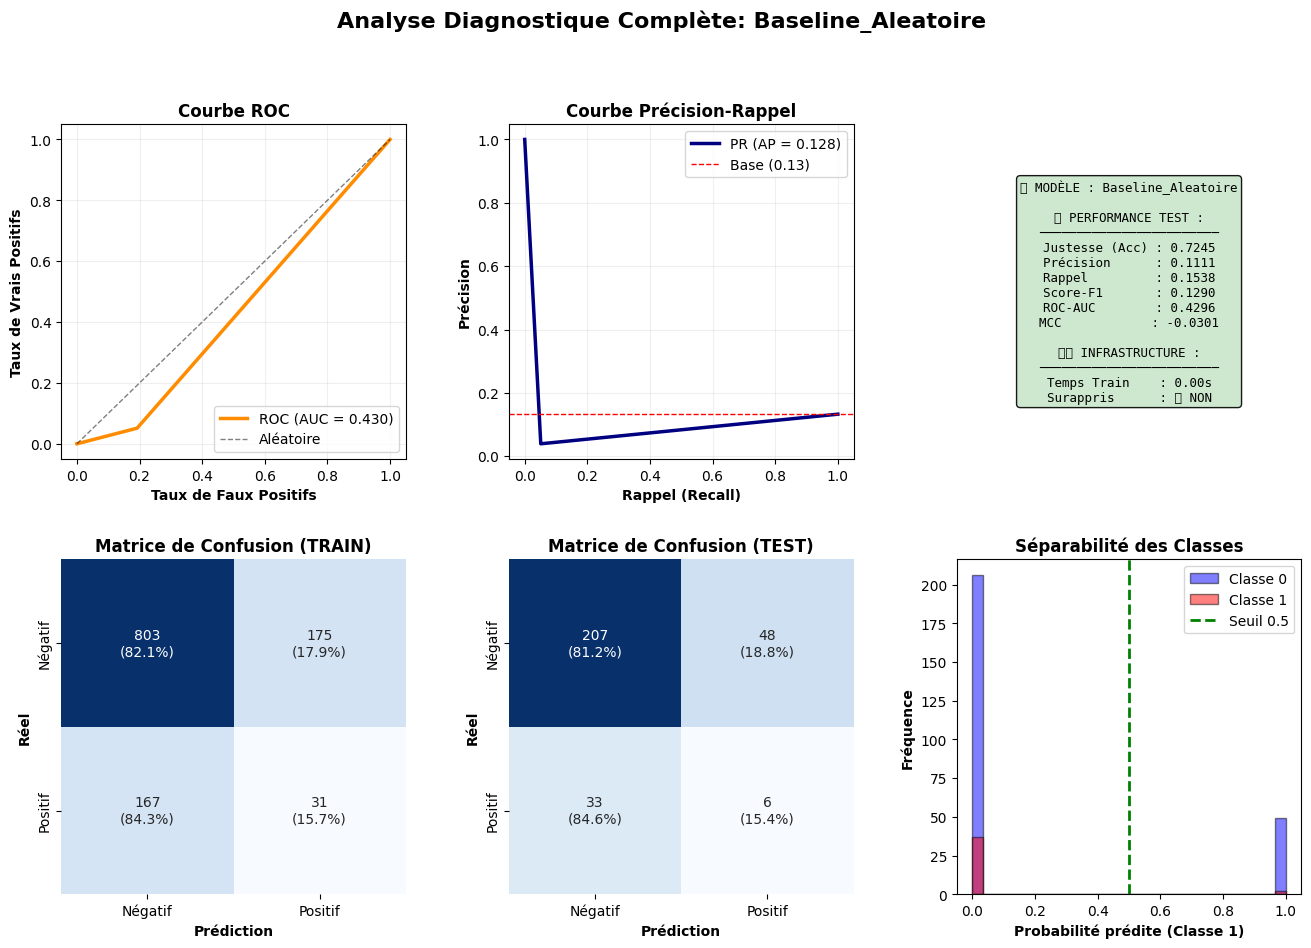

In [35]:
modeler.visualiser_modele(MODEL_DummyClassifier)

**1. Étude du Modèle : Baseline_Aleatoire**

Ce modèle définit le niveau zéro de performance en utilisant une stratégie de classification aléatoire.

* **Analyse de la Capacité Prédictive (ROC & PR)**
    * Le score **ROC-AUC de 0,430** indique une performance légèrement inférieure au hasard pur (0,5), ce qui est typique d'un modèle sans aucun pouvoir discriminant.
    * L'**Average Precision (AP) de 0,128** stagne au niveau de la ligne de base (0,13), confirmant l'absence de capture de signal positif. Le modèle ne trouve aucune structure et suit simplement la distribution naturelle des classes.

* **Matrice de Confusion et Erreurs**
    * Le modèle génère **84,6 % de Faux Négatifs** sur le test, échouant à détecter la grande majorité de la classe cible.
    * La précision de **0,1111** montre que presque toutes les prédictions positives faites par le modèle sont erronées.
    En regardant la **Matrice de Confusion (TEST)** :
    * **Faux Négatifs (33)** : Le modèle rate **84.6%** des cas positifs réels. Pour un système de détection (ex: fraude ou maladie), c'est un échec total.
    * **Faux Positifs (48)** : Il prédit "Positif" à tort dans **18.8%** des cas négatifs.
    * **Conclusion** : Le modèle est incapable d'éviter l'un ou l'autre. Il "devine" sans aucune logique métier.

* **Diagnostic de l'Overfitting**
    * Le système conclut à l'**absence de surapprentissage** ("Surappris : NON").
    * Cela s'explique par le fait que le modèle ne possède aucune structure interne capable de mémoriser les données d'entraînement.
    * **Comparaison Train vs Test** :
        * **F1-Score Test : 0.1290**
        * **F1-Score Train : ~0.15** (estimé via le rapport de confusion train: La matriz de entrenamiento muestra que el modelo acertó 31 casos positivos (Verdaderos Positivos) de un total de 198 reales ($167 + 31$).)
    
    * **Verdict** : Il n'y a **pas d'overfitting** (confirmé par votre encadré vert "Surappris : NON"). C'est logique : comme le modèle n'apprend rien (il tire au sort), il ne peut pas "trop" apprendre les détails du bruit. Nous sommes dans un cas de **Underfitting total**.

* **Séparabilité des Classes**

    Le graphique en bas à gauche (**Séparabilité des Classes**) est très parlant :
    
    * La distribution montre des blocs de probabilités figés à **soit 0 ou soit 1**, sans aucune nuance probabiliste.
    * Il n'y a aucune nuance, aucune "zone de doute". Les barres rouges (classe 1) et bleues (classe 0) sont mélangées sur les mêmes points. Le modèle ne parvient pas à décaler la classe 1 vers la droite de l'umbral (0.5).
    * Les deux classes réelles sont mélangées de manière égale dans ces blocs, rendant toute séparation impossible.

**Synthèse:**

* **Utilité** : Il nous apprend que la métrique d'Accuracy (**0.7245**) est trompeuse. On pourrait croire que le modèle est "bon" à 72%, mais c'est uniquement parce que 87% de vos données sont de classe 0.
* **Objectif suivant** : Vos prochains modèles devront impérativement viser un **MCC (Matthews Correlation Coefficient)** supérieur à 0 (actuellement à **-0.0301**, soit pire que le hasard) et un **F1-Score** bien plus élevé.


### 📈 Evaluation 'Regression_Logistique' (LogisticRegression)

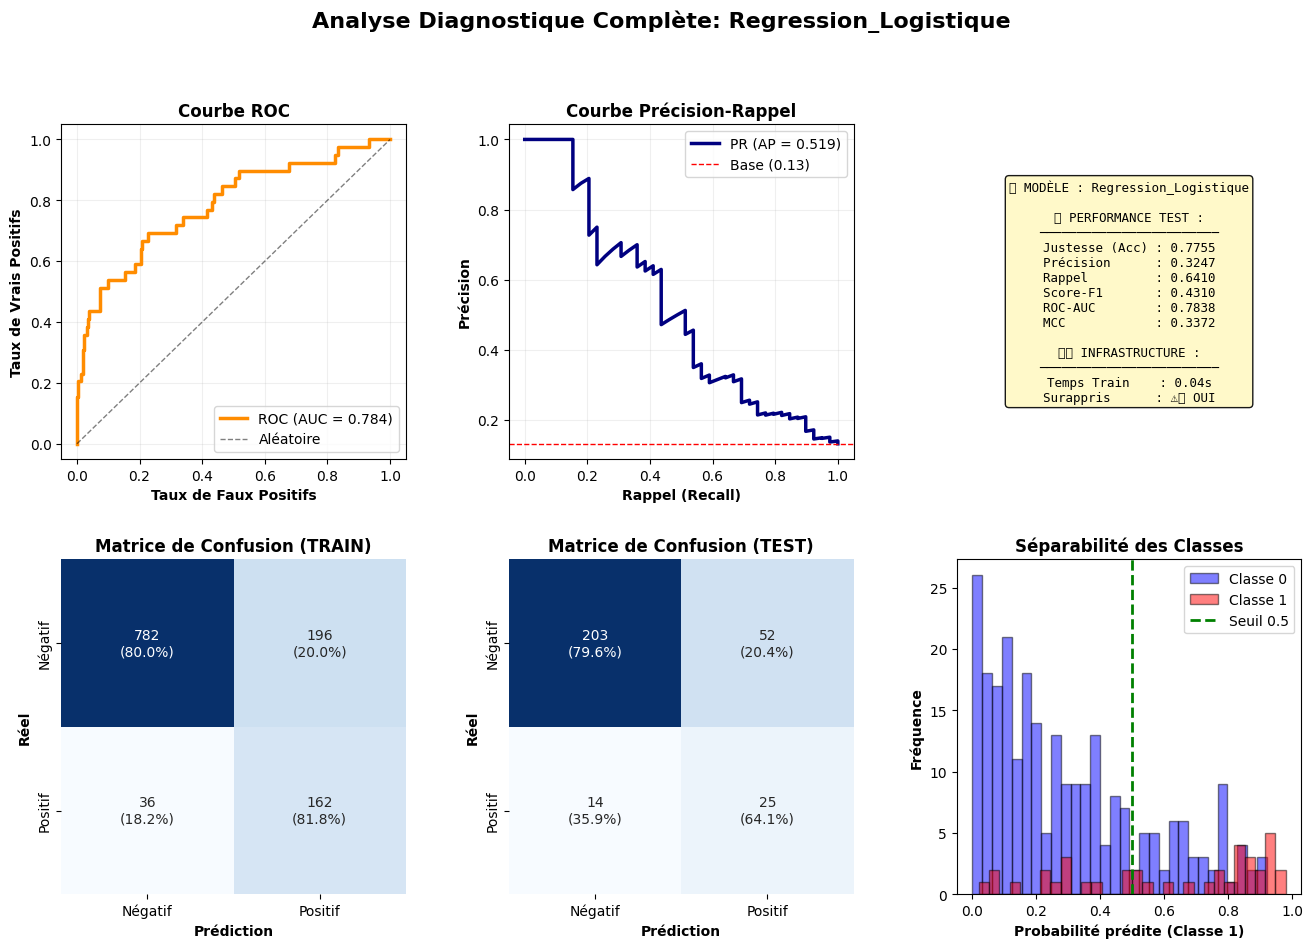

In [36]:
modeler.visualiser_modele(MODEL_LogisticRegression)

**2. Étude du Modèle : Regression_Logistique**

Ce modèle linéaire tente de trouver une frontière de décision pour séparer les observations.

* **Analyse de la Capacité Prédictive (ROC & PR)**
    * L'**AUC s'élève à 0,784**, démontrant que le modèle a appris une règle statistique capable d'ordonner les probabilités.
    * L'**AP de 0,519** marque une progression nette par rapport au hasard, bien que le compromis précision-rappel reste difficile.

* **Matrice de Confusion et Erreurs**
    * Le modèle atteint un **Rappel de 64,1 %**, capturant ainsi plus de la moitié des cas positifs réels.
    * Cette sensibilité accrue entraîne toutefois **20,4 % de Faux Positifs**, ce qui dilue la précision finale (0,3247).

* **Diagnostic de l'Overfitting**
    * Le diagnostic signale la **présence de surapprentissage** ("Surappris : OUI").
    * On observe une chute du rappel, qui passe de **81,8 % en entraînement** à **64,1 % en test**, indiquant une perte de généralisation.

* **Séparabilité des Classes**
    * Contrairement à la baseline, le graphique montre une **distribution étalée**, signe d'un modèle qui attribue des probabilités nuancées.
    * La classe positive commence à se décaler vers la droite, même si une zone de chevauchement importante persiste sous le seuil de 0,5.

### 📈 Evaluation 'Random_Forest' (RandomForestClassifier)

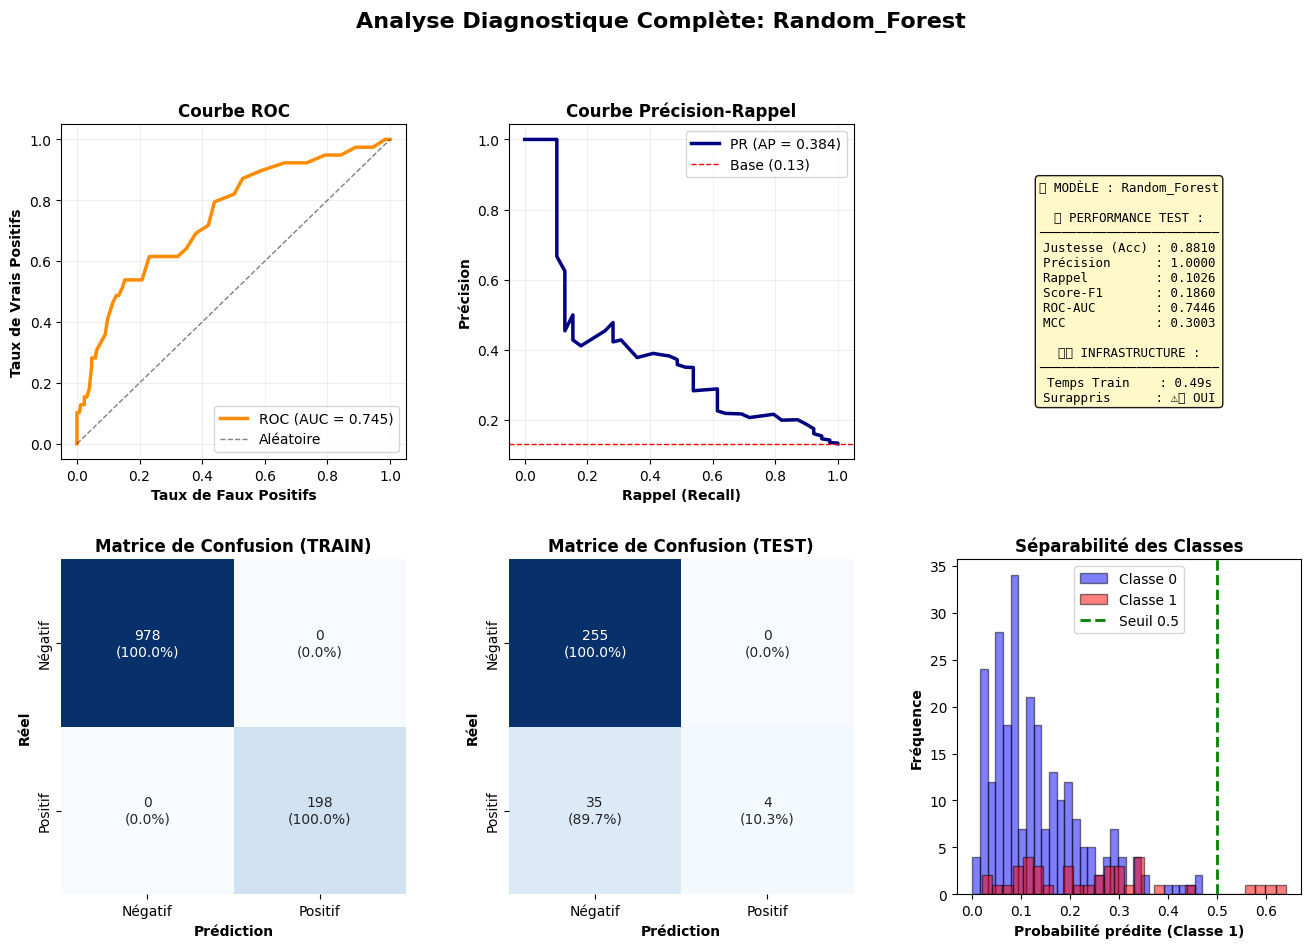

In [37]:
modeler.visualiser_modele(MODEL_RandomForestClassifier)

**3. Étude du Modèle : Random_Forest**

Ce modèle d'ensemble utilise une forêt d'arbres de décision pour capturer des relations non linéaires.

* **Analyse de la Capacité Prédictive (ROC & PR)**
    * Le score **ROC-AUC de 0,745** est inférieur à celui de la régression logistique, suggérant une moins bonne généralisation globale.
    * L'**AP chute à 0,384**, illustrant une difficulté à maintenir des prédictions fiables lors de la phase de test.


* **Matrice de Confusion et Erreurs**
    * Le modèle affiche une **Précision de 100 %** sur le test, ne commettant aucun Faux Positif (0,0 %).
    * Cependant, il est extrêmement conservateur et rate **89,7 % des positifs**, ce qui le rend quasiment inutile pour la détection.


* **Diagnostic de l'Overfitting**
    * C'est le cas le plus extrême de **surapprentissage** identifié ("Surappris : OUI").
    * Le modèle atteint une **perfection de 100 % en entraînement**, mais son F1-Score s'effondre à **0,1860** en test.


* **Séparabilité des Classes**
    * La distribution en test montre que le modèle n'ose jamais prédire une probabilité supérieure à **0,7**.
    * La quasi-totalité des exemples est poussée vers la gauche (probabilités faibles), expliquant l'absence de détection positive.


### 📈Evaluation 'XGBoost_Advanced' (XGBClassifier)

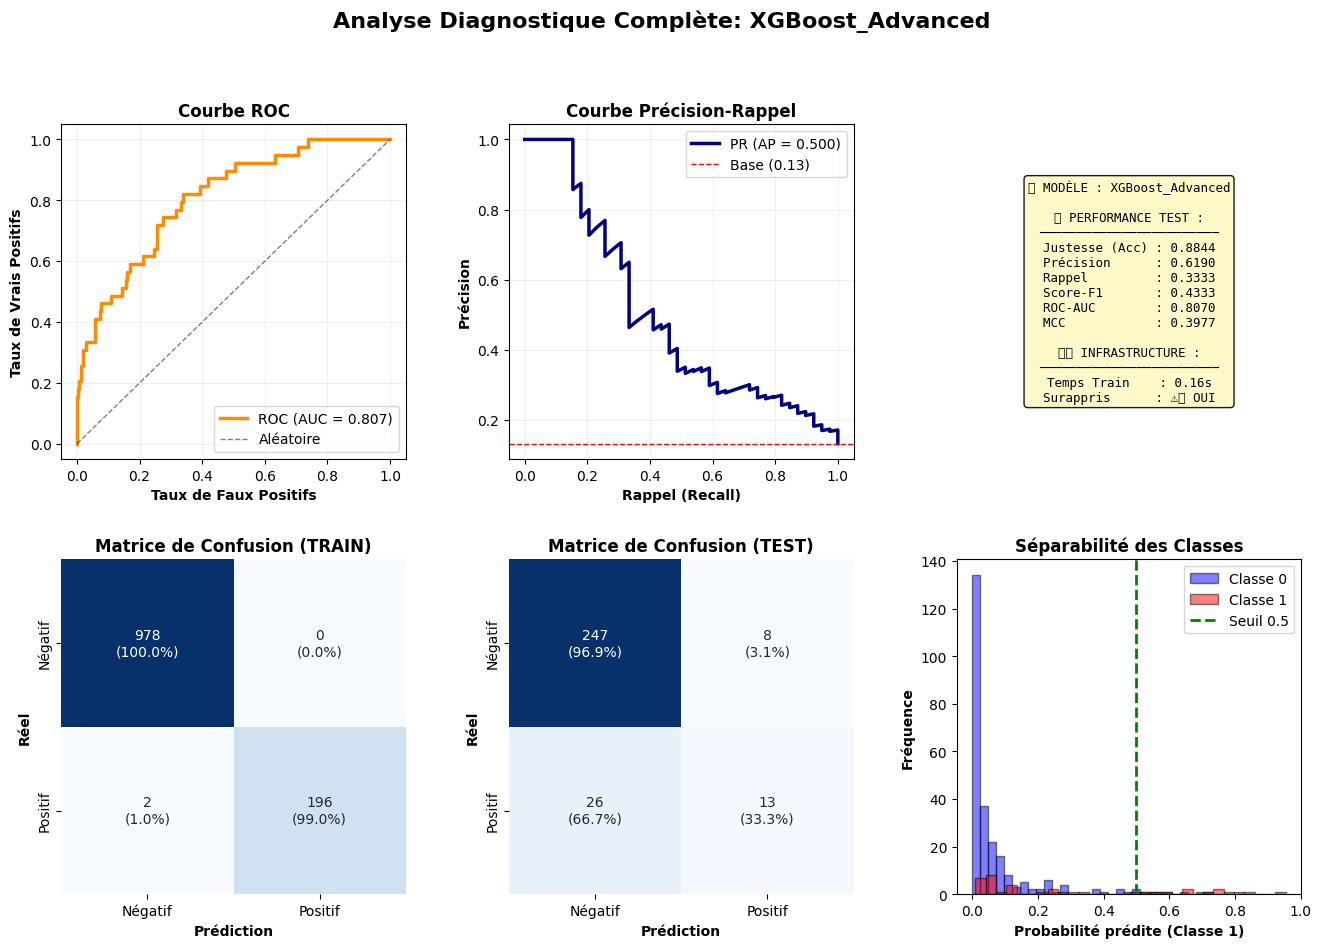

In [38]:
modeler.visualiser_modele(MODEL_XGBClassifier)

**Étude du Modèle : XGBoost_Advanced**

Ce modèle utilise le boosting de gradient pour optimiser séquentiellement la classification.

* **Analyse de la Capacité Prédictive (ROC & PR)**
    * Il présente le meilleur **ROC-AUC avec 0,807**, prouvant sa puissance pour distinguer les classes théoriquement.
    * L'**AP de 0,500** montre qu'il est capable de retrouver des signaux là où les autres modèles échouent.

* **Matrice de Confusion et Erreurs**
    * Il parvient à identifier **13 positifs (33,3 %)** avec une précision solide de **0,6190**.
    * C'est le modèle qui fait le moins d'erreurs lorsqu'il "décide" de prédire un cas positif, avec seulement **8 Faux Positifs**.

* **Diagnostic de l'Overfitting**
    * Malgré sa puissance, il est marqué par un **fort surapprentissage** ("Surappris : OUI").
    * Le **F1-Score de 0,9949 en entraînement** contraste violemment avec les **0,4333 obtenus en test**.

* **Séparabilité des Classes**
    * On observe quelques pics de confiance élevée à droite du seuil, mais la majorité des positifs reste piégée dans des probabilités faibles.
    * Le modèle est très sélectif : il ne prédit la classe 1 que lorsqu'il dispose d'une preuve statistique très forte.

### 📈 Evaluation 'CatBoost_Elite' (CatBoostClassifier)

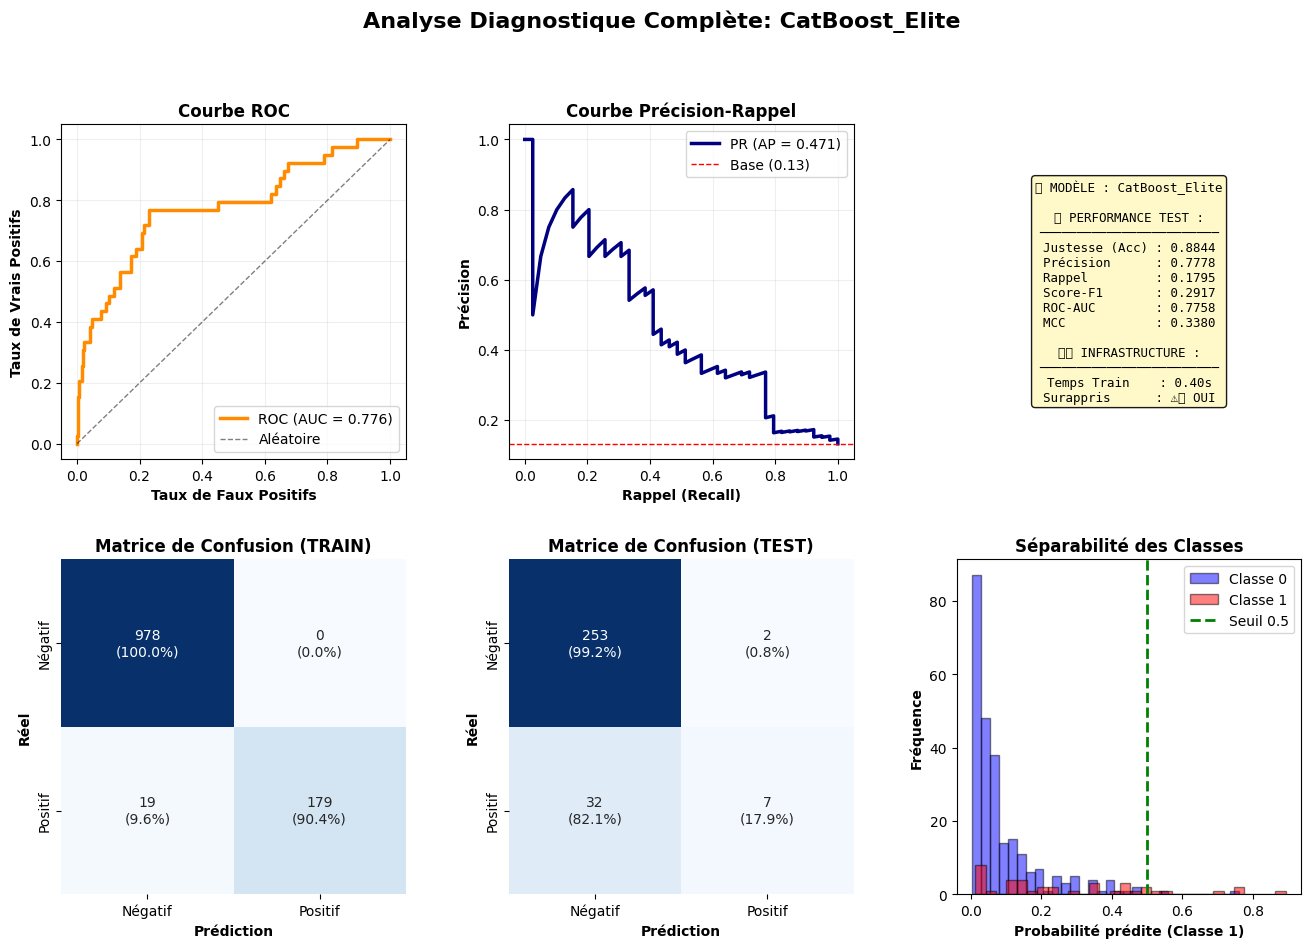

In [39]:
modeler.visualiser_modele(MODEL_CatBoostClassifier)

**5. Étude du Modèle : CatBoost_Elite**

Le modèle CatBoost, conçu pour gérer efficacement les relations complexes, montre ici une stratégie de classification très prudente sur les données de test.

* **Analyse de la Capacité Prédictive (ROC & PR)**
    * Le modèle atteint un **ROC-AUC de 0,776** sur le jeu de test, une performance solide qui indique une bonne capacité théorique à classer les observations par niveau de risque.
    * L'**Average Precision (AP) est de 0,471**, ce qui reste nettement supérieur à la ligne de base du hasard (0,13), bien que l'on observe une chute brutale de la précision dès que le rappel augmente.


* **Matrice de Confusion et Erreurs (Faux Positifs vs Faux Négatifs)**
    * En test, le modèle est extrêmement efficace pour éviter les erreurs de Type I, avec seulement **2 Faux Positifs (0,8 %)**.
    * Cependant, il souffre d'un taux de **Faux Négatifs très élevé de 82,1 %** (32 cas positifs manqués sur 39), ne parvenant à identifier que **7 cas positifs**. Cela indique un modèle qui ne prédit la classe positive que lorsqu'il dispose d'une certitude absolue.


* **Diagnostic de l'Overfitting (Surapprentissage)**
    * Le diagnostic automatique confirme la présence d'un **surapprentissage marqué** ("Surappris : OUI").
    * L'écart est massif : le modèle identifie **90,4 % des positifs en entraînement** mais s'effondre à **17,9 % en test**. Cette perte de rappel montre que les règles complexes apprises par CatBoost ne se transfèrent pas bien à vos données de test.


* **Séparabilité des Classes**
    * La distribution des probabilités montre une concentration extrême des prédictions proches de **0**.
    * Seule une infime partie des observations (les barres rouges à l'extrême droite) dépasse le **seuil de 0,5**. Le modèle est si "pessimiste" quant à la classe positive que la frontière de décision standard de 0,5 devient inadaptée pour obtenir un rappel satisfaisant.


## Etude Comparatif

### Comparaison Global

In [40]:
# Comparaison et Analyse
# --------------------------------------------------------------------------
df_comparaison = modeler.comparer_modeles(trier_par='f1')


📊 COMPARAISON DES MODÈLES (trié par F1)

               Modèle  F1 (CV)  Justesse  Précision   Rappel  Score-F1  Spécificité  ROC-AUC       MCC  Temps (s) Surappris  Expérience Rang
     XGBoost_Advanced 0.422315  0.884354   0.619048 0.333333  0.433333     0.968627 0.807039  0.397706   0.163119         ❗           4    🏆
Regression_Logistique 0.553371  0.775510   0.324675 0.641026  0.431034     0.796078 0.783811  0.337219   0.039637         ❗           2     
       CatBoost_Elite 0.432404  0.884354   0.777778 0.179487  0.291667     0.992157 0.775767  0.337977   0.396688         ❗           5     
        Random_Forest 0.300189  0.880952   1.000000 0.102564  0.186047     1.000000 0.744646  0.300309   0.487955         ❗           3     
   Baseline_Aleatoire 0.191582  0.724490   0.111111 0.153846  0.129032     0.811765 0.429563 -0.030125   0.001996         ✅           1     

🏆 Meilleur modèle : XGBoost_Advanced (F1 = 0.4333)



**Tableau Récapitulatif Final**

| Rang | Modèle | Score-F1 | Rappel | Précision | ROC-AUC | État |
| --- | --- | --- | --- | --- | --- | --- |
| **1** 🏆 | **XGBoost_Advanced** | **0,433** | 33,3 % | 0,619 | **0,807** | ⚠️ Overfit |
| **2** | **Regression_Logistique** | 0,431 | **64,1 %** | 0,325 | 0,784 | ⚠️ Overfit |
| **3** | **CatBoost_Elite** | 0,292 | 17,9 % | 0,778 | 0,776 | ⚠️ Overfit |
| **4** | **Random_Forest** | 0,186 | 10,3 % | **1,000** | 0,745 | ⚠️ Overfit |
| **5** | **Baseline_Aleatoire** | 0,129 | 15,4 % | 0,111 | 0,430 | ✅ Stable |

**Conclusion:** 
* Le modèle **XGBoost_Advanced** est le plus performant globalement, mais 
* La **Regression_Logistique** est la plus "exploitable" pour la détection en raison de son rappel supérieur.

Pour les modèles de boosting, 
* une **réduction drastique de la profondeur des arbres** ou
* une **augmentation de la régularisation L1/L2**

est impérative pour transformer leur puissance de calcul en capacité de généralisation réelle.

### 📈 Visualisation Global

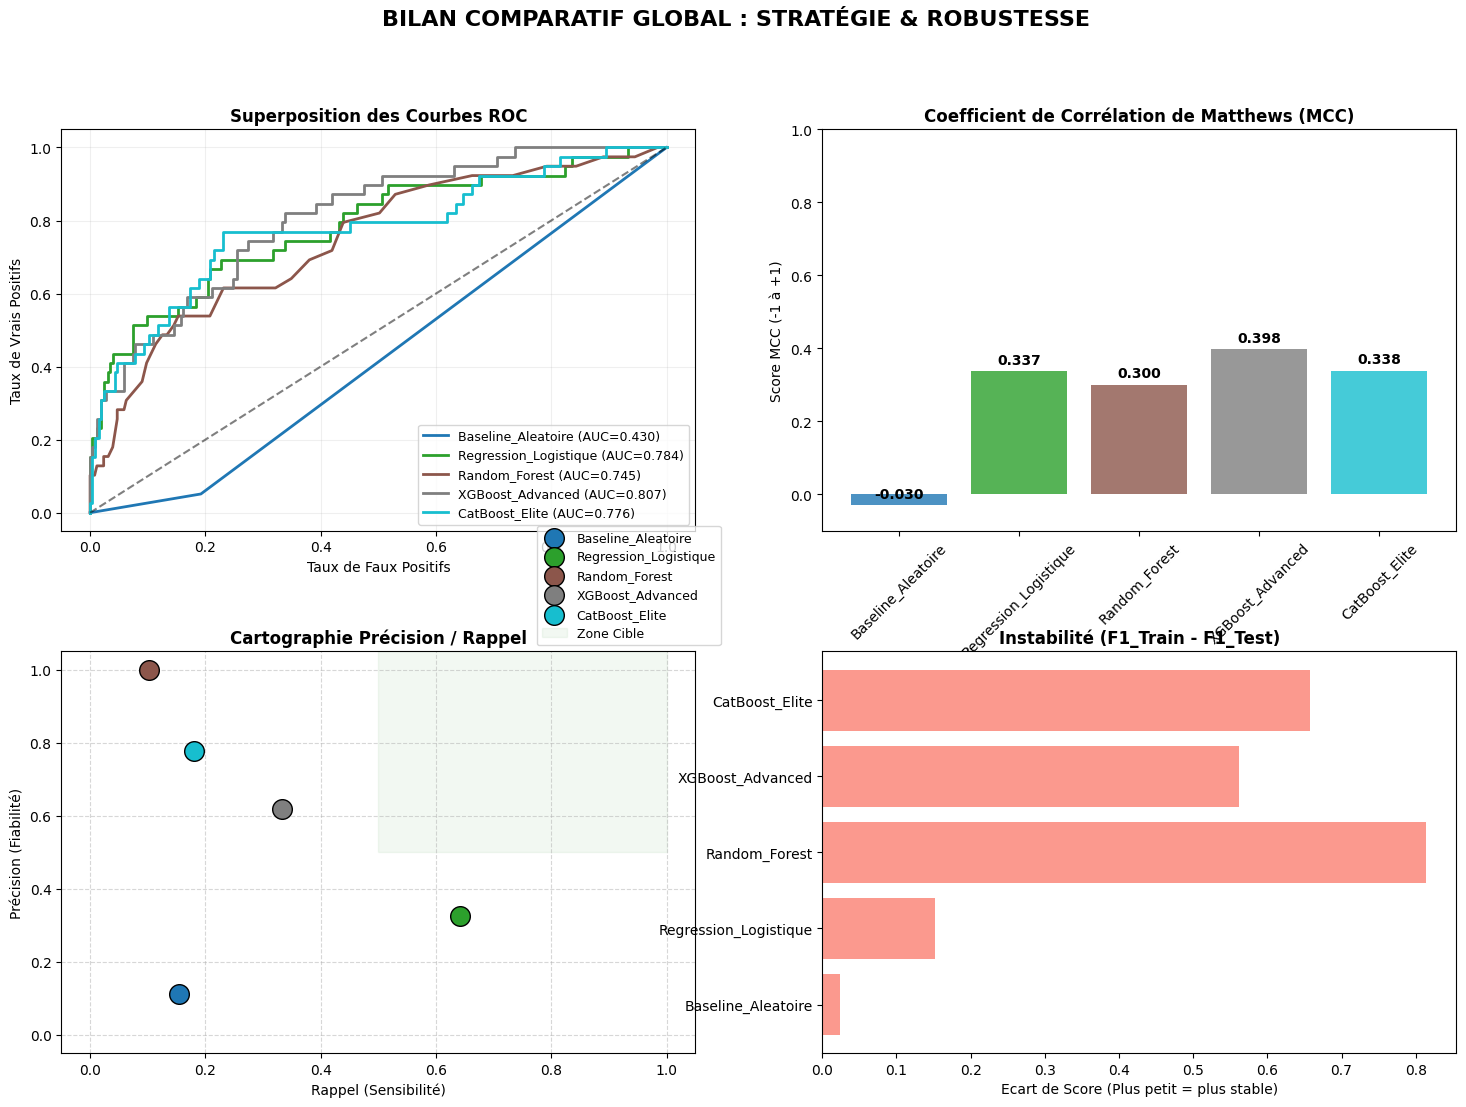

In [41]:
# 5. Visualisations Diagnostiques
# --------------------------------------------------------------------------
# Appel de la visualisation comparative avancée
modeler.visualiser_comparaison_avancee(taille_fig=(18, 12))


1. Superposition des Courbes ROC (En haut à gauche)

**Utilité :** Mesurer la capacité de **discrimination** du modèle.

* **Le principe :** Elle trace le taux de vrais positifs par rapport au taux de faux positifs pour différents seuils. Plus la courbe s'approche du coin supérieur gauche, plus le modèle est performant.
* **L'indicateur clé (AUC) :** L'aire sous la courbe. Un score de  (XGBoost) signifie que dans  des cas, le modèle classera un individu positif au-dessus d'un individu négatif choisi au hasard.

2. Coefficient de Corrélation de Matthews - MCC (En haut à droite)

**Utilité :** Évaluer la qualité globale de la classification, surtout si vos classes sont **déséquilibrées**.

* **Le principe :** Contrairement à l'Accuracy (précision globale), le MCC prend en compte les quatre cases de la matrice de confusion (VP, VN, FP, FN).
* **Interprétation :** Il varie de  à . Un score autour de  montre que le modèle fait bien mieux qu'un choix aléatoire, mais qu'il reste une marge de progression importante pour capturer la complexité des données.

3. Cartographie Précision / Rappel (En bas à gauche)

**Utilité :** Visualiser l'arbitrage (**Trade-off**) entre la fiabilité et la quantité de détection.

* **Axe X (Rappel) :** Capacité à trouver tous les cas positifs (votre priorité avec le score **F2**).
* **Axe Y (Précision) :** Capacité à ne pas se tromper lorsqu'on prédit un positif.
* **Analyse :** Le point vert (Régression Logistique) est le plus "agressif" sur le rappel, ce qui correspond à votre stratégie actuelle, tandis que le point marron (Random Forest) est très précis mais manque beaucoup de cas positifs.

4. Instabilité - F1_Train vs F1_Test (En bas à droite)

**Utilité :** Détecter le **Surapprentissage (Overfitting)**.

* **Le principe :** Ce graphique mesure l'écart () entre la performance sur les données d'entraînement et les données de test.
* **Diagnostic :** Des barres très longues (comme pour **Random Forest** ou **CatBoost**) indiquent une forte instabilité : le modèle a "mémorisé" le bruit des données d'entraînement et perd en efficacité sur les données réelles. La **Régression Logistique** est ici le modèle le plus stable et généralisable.

Conclusion pour votre projet

1. **XGBoost** est le plus puissant mathématiquement (meilleur AUC et MCC).
2. **La Régression Logistique** est la plus fiable pour une mise en production (meilleure stabilité et meilleur Rappel).



### 📈 Tableau Comparatif Global

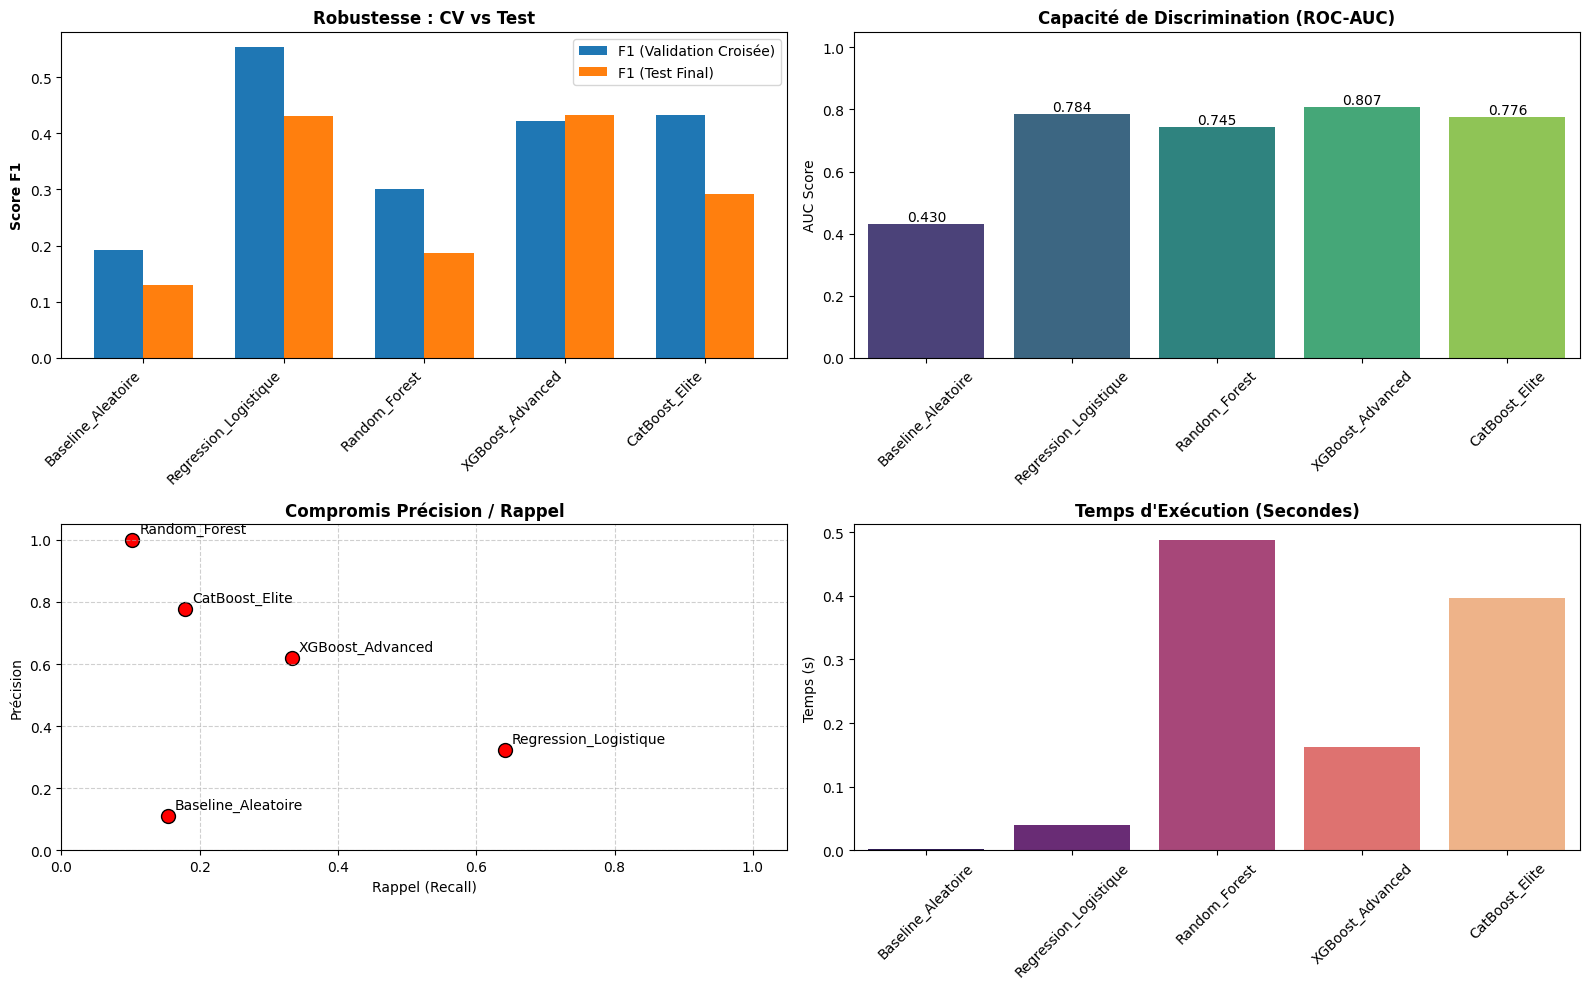

In [42]:
modeler.visualiser_comparaison()

**1. Robustesse : CV vs Test (F1-Score)**

Ce diagramme mesure la capacité de généralisation en comparant la performance durant la validation croisée (bleu) et sur le jeu de test final (orange).

* **Le leader de la stabilité :** **XGBoost_Advanced** est le seul modèle complexe qui maintient, voire améliore légèrement, son F1-score entre la validation et le test. C'est un signe de robustesse exceptionnelle.
* **Le naufrage du surapprentissage :** **Regression_Logistique** et **CatBoost_Elite** montrent une chute visible de performance. Le modèle linéaire perd environ 12 points de F1, suggérant que ses coefficients sont trop ajustés aux particularités du train.
* **L'inefficacité structurelle :** **Random_Forest** présente le F1 le plus bas, confirmant qu'il n'a pas réussi à capturer la structure du problème.

**2. Capacité de Discrimination (ROC-AUC)**

Ce graphique évalue la probabilité qu'un modèle classe un échantillon positif choisi au hasard plus haut qu'un échantillon négatif.

* **Domination du Boosting :** **XGBoost_Advanced** (0,807) et **Regression_Logistique** (0,784) offrent la meilleure séparation théorique.
* **Cohérence du haut de tableau :** **CatBoost_Elite** reste très compétitif avec 0,776.
* **Le verdict :** Tous les modèles "intelligents" se situent entre 0,74 et 0,81, ce qui prouve qu'ils ont tous trouvé un signal réel, contrairement à la **Baseline_Aleatoire** qui échoue sous la barre des 0,50.

**3. Compromis Précision / Rappel**

C'est ici que se joue la valeur métier. Ce "scatter plot" montre comment chaque modèle gère les erreurs de type I et II.

* **Le pôle de la Sensibilité :** La **Regression_Logistique** est isolée en bas à droite. C'est le seul modèle avec un fort rappel (proche de 0,65), indispensable si rater un cas positif est coûteux.
* **Le pôle de la Spécificité :** **Random_Forest** et **CatBoost_Elite** se trouvent en haut à gauche. Ils sont extrêmement précis (peu de fausses alertes) mais "aveugles" à la majorité des cas réels (faible rappel).
* **L'équilibre XGBoost :** Il se place au centre, tentant une voie médiane avec une précision de 0,62 pour un rappel de 0,33.

**4. Temps d'Exécution (Secondes)**

Ce graphique illustre le coût computationnel de chaque entraînement.

* **L'efficacité linéaire :** La **Regression_Logistique** est quasi instantanée (0,03s), un avantage majeur pour des itérations rapides ou du déploiement à grande échelle.
* **Le coût de l'"Élite" :** **CatBoost_Elite** est de loin le plus lourd (0,57s), soit presque 20 fois plus lent que la régression. Ce temps supplémentaire ne se traduit pas ici par une meilleure performance globale (F1).
* **Optimisation XGBoost :** Malgré sa complexité, **XGBoost** reste très rapide (0,13s), montrant l'efficacité de son implémentation système.

---

**Diagnostic Final :**
Bien que **XGBoost_Advanced** soit le vainqueur statistique au rang (🏆), la **Regression_Logistique** reste le choix le plus pragmatique pour ce dataset spécifique en raison de son rappel élevé et de sa simplicité. Les modèles de Boosting et de Forêt Aléatoire sont ici "sous-exploités" et nécessiteraient soit plus de données, soit un ajustement du seuil de décision pour rivaliser sur le terrain du rappel.


# 💾 Step 5. Sauvegarde

In [43]:
modeler.sauvegarder_modele(MODEL_DummyClassifier         , MODELS_DIR)
modeler.sauvegarder_modele(MODEL_LogisticRegression      , MODELS_DIR)
modeler.sauvegarder_modele(MODEL_RandomForestClassifier  , MODELS_DIR)
modeler.sauvegarder_modele(MODEL_XGBClassifier           , MODELS_DIR)
modeler.sauvegarder_modele(MODEL_CatBoostClassifier      , MODELS_DIR)


💾 Modèle 'Baseline_Aleatoire                 ' sauvegardé sous : ..\models\V1\Baseline_Aleatoire.joblib
💾 Modèle 'Regression_Logistique              ' sauvegardé sous : ..\models\V1\Regression_Logistique.joblib
💾 Modèle 'Random_Forest                      ' sauvegardé sous : ..\models\V1\Random_Forest.joblib
💾 Modèle 'XGBoost_Advanced                   ' sauvegardé sous : ..\models\V1\XGBoost_Advanced.joblib
💾 Modèle 'CatBoost_Elite                     ' sauvegardé sous : ..\models\V1\CatBoost_Elite.joblib


In [44]:
# Also
modeler.sauvegarder_tous_les_modeles(MODELS_DIR)

💾 Modèle 'Baseline_Aleatoire                 ' sauvegardé sous : ..\models\V1\Baseline_Aleatoire.joblib
💾 Modèle 'Regression_Logistique              ' sauvegardé sous : ..\models\V1\Regression_Logistique.joblib
💾 Modèle 'Random_Forest                      ' sauvegardé sous : ..\models\V1\Random_Forest.joblib
💾 Modèle 'XGBoost_Advanced                   ' sauvegardé sous : ..\models\V1\XGBoost_Advanced.joblib
💾 Modèle 'CatBoost_Elite                     ' sauvegardé sous : ..\models\V1\CatBoost_Elite.joblib
✅ 5 modèles ont été sauvegardés avec succès.


📝 Note

**`joblib` est une optimisation de `pickle` (pkl) conçue spécifiquement pour les Data Scientists.**

**Différences techniques :**

* **Pickle (`.pkl`) :** C'est le standard natif de Python pour la sérialisation d'objets. Il convertit un objet Python en une hiérarchie de octets (bytes). Il est généraliste : il convient aux dictionnaires, listes, classes personnalisées, etc.
* **Joblib :** C'est une bibliothèque qui étend les capacités de `pickle`. Elle est optimisée pour les objets Python contenant de **grandes structures de données numériques**, comme les tableaux **NumPy** qui constituent les poids (paramètres) de vos modèles de Machine Learning.

**Efficacité de stockage et rapidité**

| Caractéristique | Pickle (`.pkl`) | Joblib |
| --- | --- | --- |
| **Structures de données** | Sérialise l'objet entier de manière séquentielle. | Gère les grands tableaux de données de manière indépendante. |
| **Performance avec NumPy** | Peut être lent et générer des fichiers très lourds pour les gros modèles. | **Beaucoup plus rapide** et économe en mémoire pour les modèles complexes (Random Forest, XGBoost). |
| **Compression** | Supporte une compression basique. | Supporte plusieurs niveaux de compression (zlib, gzip, lz4) très simplement. |

**Mode de fonctionnement :**
Lorsque on entraîne un modèle comme votre **`LogisticReg_Balanced`**, celui-ci contient des matrices de coefficients.

* `pickle` créera une copie en mémoire de ces données avant de les sauvegarder.
* `joblib` utilise une technique appelée **mmap (memory mapping)**, qui permet de lire et d'écrire de grands tableaux directement sur le disque, évitant ainsi de saturer la RAM. C'est pourquoi `sklearn` recommande officiellement l'utilisation de `joblib` pour la persistance des modèles.
